# Weave Annotation Queue Report
Kitchen-sink visual analytics examples for a single annotation queue.

**Prerequisites:**
```
pip install altair wordcloud matplotlib pandas numpy wandb weave requests
```

In [ ]:
# ─── Configuration ──────────────────────────────────────────────────────────
WANDB_API_KEY = ""
ENTITY_PROJECT = "wandb-designers/martin-weave-test"
QUEUE_ID = "019c7674-fc23-7498-8c35-c842d771c33c"
DEDUP_STRATEGY = "latest"  # "latest" = keep last annotation per (call, scorer, annotator)
                           # "all"    = keep every annotation (duplicates counted separately)
                           # "mean"   = average duplicates into one value per (call, scorer, annotator)
# ────────────────────────────────────────────────────────────────────────────

In [ ]:
# @title
import os
import wandb
import weave
import requests
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime, timezone
from IPython.display import display, Markdown, HTML
from weave.trace_server.trace_server_interface import (
    AnnotationQueuesQueryReq,
    AnnotationQueueItemsQueryReq,
    AnnotationQueuesStatsReq,
    AnnotationQueueReadReq,
    CallsFilter,
)
from weave.trace_server.interface.query import Query

CALL_URL_TEMPLATE = "https://wandb.ai/{entity}/{project}/weave/calls/{call_id}"

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
# @title

def resolve_wb_user_ids(api_key, user_ids):
    """Resolve base64-encoded W&B user IDs to usernames."""
    query = "query($id: ID) { user(id: $id) { username name email } }"
    mapping = {}
    for uid in set(uid for uid in user_ids if uid):
        try:
            resp = requests.post(
                "https://api.wandb.ai/graphql",
                auth=("api", api_key),
                json={"query": query, "variables": {"id": uid}},
                timeout=10,
            )
            resp.raise_for_status()
            body = resp.json()
            if "errors" in body:
                mapping[uid] = uid
                continue
            user_info = body.get("data", {}).get("user") or {}
            mapping[uid] = user_info.get("username") or user_info.get("name") or uid
        except Exception:
            mapping[uid] = uid
    return mapping


wandb.login(key=WANDB_API_KEY)
client = weave.init(ENTITY_PROJECT)
project_id = f"{client.entity}/{client.project}"

print("Loading queue data...")

queue = client.server.annotation_queue_read(
    AnnotationQueueReadReq(project_id=project_id, queue_id=QUEUE_ID)
).queue

stats = client.server.annotation_queues_stats(
    AnnotationQueuesStatsReq(project_id=project_id, queue_ids=[queue.id])
).stats[0]

scorers = {}
for ref_uri in queue.scorer_refs:
    scorers[ref_uri] = weave.ref(ref_uri).get()

items_res = client.server.annotation_queue_items_query(
    AnnotationQueueItemsQueryReq(project_id=project_id, queue_id=queue.id, limit=10_000)
)
items_df = pd.DataFrame([{
    "item_id": i.id,
    "call_id": i.call_id,
    "op_name": i.call_op_name,
    "trace_id": i.call_trace_id,
    "state": i.annotation_state,
    "annotator": i.annotator_user_id,
    "added_at": i.created_at,
    "updated_at": i.updated_at,
} for i in items_res.items])

feedback_raw = list(client.get_feedback(
    query=Query(**{
        "$expr": {"$eq": [{"$getField": "queue_id"}, {"$literal": queue.id}]}
    }),
    limit=10_000,
))
_feedback_columns = [
    "feedback_id", "call_id", "annotation_ref", "scorer_name",
    "scorer_type", "value", "annotator", "created_at",
]
if feedback_raw:
    feedback_df = pd.DataFrame([{
        "feedback_id": f.id,
        "call_id": f.weave_ref.split("/")[-1] if f.weave_ref else None,
        "annotation_ref": f.annotation_ref,
        "scorer_name": scorers[f.annotation_ref].name if f.annotation_ref and f.annotation_ref in scorers else None,
        "scorer_type": (scorers[f.annotation_ref].field_schema or {}).get("type")
                       if f.annotation_ref and f.annotation_ref in scorers else None,
        "value": f.payload.get("value") if f.payload else None,
        "annotator": f.wb_user_id,
        "created_at": pd.to_datetime(f.created_at, utc=True),
    } for f in feedback_raw])
else:
    feedback_df = pd.DataFrame(columns=_feedback_columns)

# Resolve annotator IDs
all_user_ids = set()
if not items_df.empty:
    all_user_ids.update(items_df["annotator"].dropna().unique())
if not feedback_df.empty:
    all_user_ids.update(feedback_df["annotator"].dropna().unique())

USER_MAP = {}
if all_user_ids:
    USER_MAP = resolve_wb_user_ids(WANDB_API_KEY, all_user_ids)
    if not items_df.empty:
        items_df["annotator"] = items_df["annotator"].map(lambda x: USER_MAP.get(x, x))
    if not feedback_df.empty:
        feedback_df["annotator"] = feedback_df["annotator"].map(lambda x: USER_MAP.get(x, x))

# Deduplication
if DEDUP_STRATEGY == "latest" and not feedback_df.empty:
    feedback_df = (
        feedback_df
        .sort_values("created_at")
        .groupby(["call_id", "annotation_ref", "annotator"], as_index=False)
        .last()
    )
elif DEDUP_STRATEGY == "mean" and not feedback_df.empty:
    def _agg_value(vals):
        numeric = pd.to_numeric(vals, errors="coerce")
        if numeric.notna().all():
            return numeric.mean()
        return vals.iloc[-1]

    feedback_df = (
        feedback_df
        .sort_values("created_at")
        .groupby(["call_id", "annotation_ref", "annotator"], as_index=False)
        .agg({
            "feedback_id": "last",
            "scorer_name": "first",
            "scorer_type": "first",
            "value": _agg_value,
            "created_at": "max",
        })
    )

# Fetch call data (model + op) upfront
call_ids = items_df["call_id"].unique().tolist() if not items_df.empty else []
call_model_map = {}
call_op_map = {}

if call_ids:
    calls = client.get_calls(
        filter=CallsFilter(call_ids=call_ids),
        columns=["id", "inputs", "output", "summary", "op_name"],
        include_costs=True,
        limit=len(call_ids),
    )
    for call in calls:
        model = None
        if hasattr(call, "inputs") and isinstance(call.inputs, dict):
            model = call.inputs.get("model") or call.inputs.get("model_name") or call.inputs.get("model_id")
        if model is None and hasattr(call, "output") and isinstance(call.output, dict):
            model = call.output.get("model")
        if model is None and hasattr(call, "summary") and isinstance(call.summary, dict):
            usage = call.summary.get("usage") or {}
            if isinstance(usage, dict) and len(usage) == 1:
                model = list(usage.keys())[0]
            weave_info = call.summary.get("weave") or {}
            costs = weave_info.get("costs") or {}
            if isinstance(costs, dict) and len(costs) == 1 and model is None:
                model = list(costs.keys())[0]
        call_model_map[call.id] = model or "(unknown)"
        op = getattr(call, "op_name", None) or "(unknown)"
        call_op_map[call.id] = op

model_df = pd.DataFrame([
    {"call_id": cid, "model": m} for cid, m in call_model_map.items()
])
op_df = pd.DataFrame([
    {"call_id": cid, "op_name_full": op} for cid, op in call_op_map.items()
])

print(f"  {len(items_df)} items, {len(feedback_df)} feedback entries, "
      f"{len(scorers)} scorer(s), {len(call_model_map)} calls fetched")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING [wandb.login()] Changing session credentials to explicit value for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Output()

weave: Logged in as Weights & Biases user: martin-mark.
weave: View Weave data at https://wandb.ai/wandb-designers/martin-weave-test/weave


Loading queue data...
  100 items, 875 feedback entries, 5 scorer(s), 100 calls fetched


In [ ]:
# @title

def scorer_type(ref_uri):
    """Classify a scorer as boolean, integer, number, string_enum, or string_free."""
    spec = scorers.get(ref_uri)
    if spec is None:
        return "unknown"
    schema = spec.field_schema or {}
    stype = schema.get("type", "string")
    if stype == "boolean":
        return "boolean"
    if stype == "integer":
        return "integer"
    if stype == "number":
        return "number"
    if "enum" in schema:
        return "string_enum"
    if stype == "string":
        vals = feedback_df.loc[feedback_df["annotation_ref"] == ref_uri, "value"].dropna().unique()
        if len(vals) <= 10:
            return "string_enum"
        return "string_free"
    return "unknown"


def call_url(call_id):
    return CALL_URL_TEMPLATE.format(
        entity=client.entity, project=client.project, call_id=call_id,
    )


def short_op(op_name):
    if not op_name:
        return "(unknown)"
    return str(op_name).split("/")[-1].split(":")[-1]


CHART_WIDTH = 600
CHART_HEIGHT = 350

STOPWORDS = {
    "a", "an", "the", "and", "or", "but", "is", "are", "was", "were", "be",
    "been", "being", "have", "has", "had", "do", "does", "did", "will",
    "would", "could", "should", "may", "might", "shall", "can", "need",
    "dare", "ought", "used", "to", "of", "in", "for", "on", "with", "at",
    "by", "from", "as", "into", "through", "during", "before", "after",
    "above", "below", "between", "out", "off", "over", "under", "again",
    "further", "then", "once", "here", "there", "when", "where", "why",
    "how", "all", "each", "every", "both", "few", "more", "most", "other",
    "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "just", "because", "about", "its", "it", "this",
    "that", "these", "those", "i", "me", "my", "myself", "we", "our",
    "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself",
    "they", "them", "their", "theirs", "themselves", "what", "which",
    "who", "whom", "if", "while", "up", "don", "doesn", "didn", "isn",
    "aren", "wasn", "weren", "won", "wouldn", "couldn", "shouldn",
}


def _top_words(texts, n=10):
    """Count word frequencies from an iterable of strings, excluding stopwords."""
    freq = {}
    for t in texts:
        for w in str(t).lower().split():
            w = w.strip(".,!?;:\"'()[]")
            if len(w) > 2 and w not in STOPWORDS:
                freq[w] = freq.get(w, 0) + 1
    return sorted(freq.items(), key=lambda x: -x[1])[:n]


scorer_ref_to_type = {ref: scorer_type(ref) for ref in scorers}

# Build an enriched feedback DataFrame with op + model joined in
enriched_df = feedback_df.copy()
if not enriched_df.empty:
    if not model_df.empty:
        enriched_df = enriched_df.merge(model_df, on="call_id", how="left")
        enriched_df["model"] = enriched_df["model"].fillna("(unknown)")
    else:
        enriched_df["model"] = "(unknown)"
    if not op_df.empty:
        enriched_df = enriched_df.merge(op_df, on="call_id", how="left")
        enriched_df["op"] = enriched_df["op_name_full"].apply(short_op)
    else:
        enriched_df["op"] = "(unknown)"

## Queue
Queue metadata and scoring configuration at a glance.

In [ ]:
# @title
pct_complete = stats.completed_items / stats.total_items * 100 if stats.total_items else 0
queue_info = pd.DataFrame([
    {"Field": "Name", "Value": queue.name},
    {"Field": "Description", "Value": queue.description or "(none)"},
    {"Field": "Created", "Value": str(queue.created_at)},
    {"Field": "Total Items", "Value": str(stats.total_items)},
    {"Field": "Completed", "Value": f"{stats.completed_items} ({pct_complete:.1f}%)"},
] + [
    {"Field": f"Scorer: {s.name}", "Value": (s.field_schema or {}).get("type", "?")}
    for s in scorers.values()
])
display(queue_info)

,Field,Value
0,Name,LLM Response Quality Review
1,Description,Review LLM-generated responses for factual acc...
2,Created,2026-02-19 15:11:44.206000+00:00
3,Total Items,100
4,Completed,100 (100.0%)
5,Scorer: Factually Correct,boolean
6,Scorer: Overall Quality,integer
7,Scorer: Helpfulness,number
8,Scorer: Reviewer Notes,string
9,Scorer: Response Tone,string


### Item Completion
Shows what fraction of queue items have received at least one annotation across any scorer.

In [ ]:
# @title
total_items = len(items_df)
annotated_call_ids = set(feedback_df["call_id"].unique()) if not feedback_df.empty else set()
annotated_count = len(set(items_df["call_id"]) & annotated_call_ids) if not items_df.empty else 0
unannotated_count = total_items - annotated_count
pct = annotated_count / total_items * 100 if total_items else 0

display(Markdown(f"**{annotated_count}** of **{total_items}** items have been annotated (**{pct:.1f}%**)"))

completion_data = pd.DataFrame([
    {"Status": "Annotated", "Count": annotated_count},
    {"Status": "Unannotated", "Count": unannotated_count},
])
pie = alt.Chart(completion_data).mark_arc(innerRadius=50).encode(
    theta=alt.Theta("Count:Q"),
    color=alt.Color("Status:N"),
    tooltip=["Status", "Count"],
).properties(title="Annotation Completion", width=CHART_WIDTH, height=CHART_HEIGHT)
display(pie)

**100** of **100** items have been annotated (**100.0%**)

alt.Chart(...)

### Participation
Annotator activity summary, daily annotation volume, and per-scorer coverage.
The summary table shows each annotator's total annotations, unique calls reviewed,
active days, and throughput. The line chart tracks daily annotation volume,
and the bar chart shows what percentage of queue items each scorer has covered.

In [ ]:
# @title
if not feedback_df.empty:
    # Annotator summary table
    rows = []
    for annotator, grp in feedback_df.groupby("annotator"):
        dates = grp["created_at"].dt.date
        active_days = dates.nunique()
        rows.append({
            "Annotator": annotator or "(unknown)",
            "Annotations": len(grp),
            "Unique Calls": grp["call_id"].nunique(),
            "Active Days": active_days,
            "Ann / Active Day": round(len(grp) / max(active_days, 1), 1),
            "First": grp["created_at"].min().strftime("%Y-%m-%d"),
            "Last": grp["created_at"].max().strftime("%Y-%m-%d"),
        })
    summary_table = pd.DataFrame(rows).sort_values("Annotations", ascending=False)
    display(Markdown("### Annotator Summary"))
    display(summary_table)

    # Annotations per day
    fb_daily = feedback_df.copy()
    fb_daily["date"] = fb_daily["created_at"].dt.date
    daily_counts = fb_daily.groupby("date").size().reset_index(name="Annotations")
    daily_counts["date"] = pd.to_datetime(daily_counts["date"])

    line = alt.Chart(daily_counts).mark_line(point=True).encode(
        x=alt.X("date:T", title="Date"),
        y=alt.Y("Annotations:Q", title="Annotations"),
        tooltip=["date:T", "Annotations:Q"],
    ).properties(title="Annotations Per Day", width=CHART_WIDTH, height=CHART_HEIGHT)
    display(line)

    # Coverage per scorer
    coverage_rows = []
    for ref_uri, spec in scorers.items():
        scorer_fb = feedback_df[feedback_df["annotation_ref"] == ref_uri]
        covered = scorer_fb["call_id"].nunique()
        pct = covered / total_items * 100 if total_items else 0
        coverage_rows.append({"Scorer": spec.name, "Coverage %": round(pct, 1)})
    coverage_df = pd.DataFrame(coverage_rows)

    bar = alt.Chart(coverage_df).mark_bar().encode(
        x=alt.X("Scorer:N", title="Scorer", sort="-y"),
        y=alt.Y("Coverage %:Q", title="Coverage %", scale=alt.Scale(domain=[0, 100])),
        color=alt.Color("Scorer:N", legend=None),
        tooltip=["Scorer", "Coverage %"],
    ).properties(title="Annotation Coverage Per Scorer", width=CHART_WIDTH, height=CHART_HEIGHT)
    display(bar)
else:
    display(Markdown("*No feedback data yet.*"))

### Annotator Summary

,Annotator,Annotations,Unique Calls,Active Days,Ann / Active Day,First,Last
0,martin-mark,500,100,1,500.0,2026-02-19,2026-02-19
1,martinmark,375,75,1,375.0,2026-02-19,2026-02-19


alt.Chart(...)

alt.Chart(...)

## Scores

### Score Distributions
Distribution of values for each scorer. Boolean scorers are shown as pie charts,
numeric (integer/number) as histograms, string enums (<10 unique values) as bar charts,
and free-text strings (>10 unique values) as word clouds.

### Factually Correct (`boolean`, n=175)

alt.Chart(...)

### Overall Quality (`integer`, n=175)

alt.Chart(...)

### Helpfulness (`number`, n=175)

alt.Chart(...)

### Reviewer Notes (`string_free`, n=175)

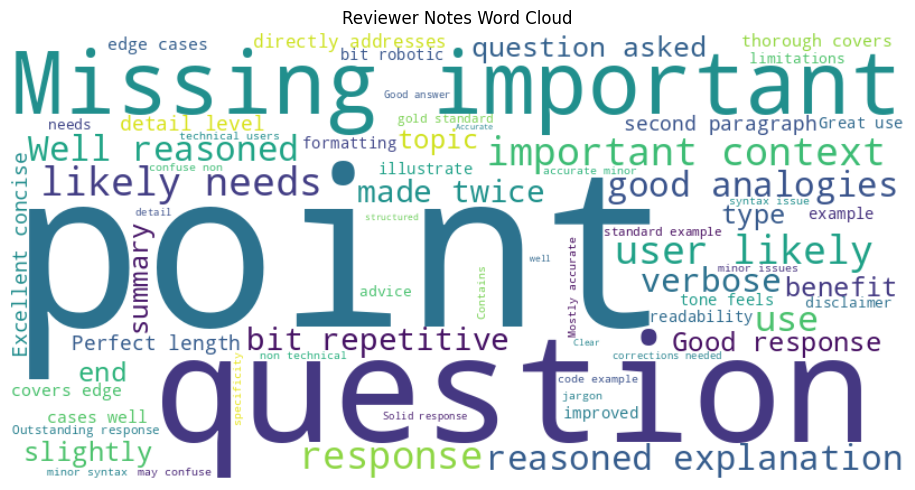

**Top 10 words:**

,#,Word,Count
0,1,response,38
1,2,question,31
2,3,good,27
3,4,needs,24
4,5,use,22
5,6,point,20
6,7,bit,20
7,8,missing,16
8,9,important,16
9,10,context,16


### Response Tone (`string_enum`, n=175)

alt.Chart(...)

In [ ]:
# @title
if not feedback_df.empty:
    for ref_uri, spec in scorers.items():
        stype = scorer_ref_to_type[ref_uri]
        group = feedback_df[feedback_df["annotation_ref"] == ref_uri]
        values = group["value"].dropna()
        if values.empty:
            continue

        display(Markdown(f"### {spec.name} (`{stype}`, n={len(values)})"))

        if stype == "boolean":
            bool_counts = values.value_counts().reset_index()
            bool_counts.columns = ["Value", "Count"]
            bool_counts["Value"] = bool_counts["Value"].astype(str)
            pie = alt.Chart(bool_counts).mark_arc(innerRadius=50).encode(
                theta=alt.Theta("Count:Q"),
                color=alt.Color("Value:N"),
                tooltip=["Value", "Count"],
            ).properties(title=f"{spec.name} Distribution", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(pie)

        elif stype in ("integer", "number"):
            nums = pd.to_numeric(values, errors="coerce").dropna()
            if nums.empty:
                continue
            hist_df = nums.reset_index(drop=True).to_frame(name="Score")
            if stype == "integer":
                bar = alt.Chart(hist_df).mark_bar().encode(
                    x=alt.X("Score:O", title="Score"),
                    y=alt.Y("count():Q", title="Count"),
                    tooltip=["Score:O", "count():Q"],
                ).properties(title=f"{spec.name} Distribution", width=CHART_WIDTH, height=CHART_HEIGHT)
            else:
                bar = alt.Chart(hist_df).mark_bar().encode(
                    x=alt.X("Score:Q", bin=alt.Bin(maxbins=20), title="Score"),
                    y=alt.Y("count():Q", title="Count"),
                    tooltip=["count():Q"],
                ).properties(title=f"{spec.name} Distribution", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(bar)

        elif stype == "string_enum":
            val_counts = values.value_counts().reset_index()
            val_counts.columns = ["Value", "Count"]
            bar = alt.Chart(val_counts).mark_bar().encode(
                x=alt.X("Value:N", title="Value", sort="-y"),
                y=alt.Y("Count:Q", title="Count"),
                color=alt.Color("Value:N", legend=None),
                tooltip=["Value", "Count"],
            ).properties(title=f"{spec.name} Distribution", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(bar)

        elif stype == "string_free":
            text = " ".join(str(v) for v in values)
            wc = WordCloud(width=800, height=400, background_color="white").generate(text)
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f"{spec.name} Word Cloud")
            plt.tight_layout()
            display(fig)
            plt.close(fig)

            top = _top_words(values)
            if top:
                display(Markdown(f"**Top 10 words:**"))
                tw_df = pd.DataFrame(top, columns=["Word", "Count"])
                tw_df.insert(0, "#", range(1, len(tw_df) + 1))
                display(tw_df)
else:
    display(Markdown("*No feedback data yet.*"))

### Scores Analysis
Detailed score analysis per scorer. For numeric scorers, a scatterplot shows
each annotation colored by annotator, plus tables of top-5 and bottom-5 calls
(requiring >= 2 annotations). For boolean/enum scorers, top-5 calls per bucket
are shown. All tables include a URL linking back to the call in W&B.

In [ ]:
# @title
def _make_call_table(call_ids_list):
    """Build a DataFrame with Call ID, Op, Model, URL for a list of call IDs."""
    rows = []
    for cid in call_ids_list:
        rows.append({
            "Call ID": cid,
            "Op": short_op(call_op_map.get(cid, "(unknown)")),
            "Model": call_model_map.get(cid, "(unknown)"),
            "URL": call_url(cid),
        })
    return pd.DataFrame(rows)


if not enriched_df.empty:
    for ref_uri, spec in scorers.items():
        stype = scorer_ref_to_type[ref_uri]
        group = enriched_df[enriched_df["annotation_ref"] == ref_uri].copy()
        if group.empty:
            continue

        display(Markdown(f"### {spec.name}"))

        if stype in ("integer", "number"):
            group["num"] = pd.to_numeric(group["value"], errors="coerce")
            scored = group.dropna(subset=["num"])
            if scored.empty:
                continue

            y_enc = alt.Y("num:Q", title="Score")
            if stype == "integer":
                schema = spec.field_schema or {}
                y_min = schema.get("minimum", int(scored["num"].min()))
                y_max = schema.get("maximum", int(scored["num"].max()))
                y_enc = alt.Y("num:Q", title="Score",
                              scale=alt.Scale(domain=[y_min, y_max]),
                              axis=alt.Axis(tickMinStep=1))
            scatter = alt.Chart(scored.reset_index()).mark_circle(size=60).encode(
                x=alt.X("index:Q", title="Annotation Index"),
                y=y_enc,
                color=alt.Color("annotator:N", title="Annotator"),
                tooltip=["call_id", "annotator", "num"],
            ).properties(title=f"{spec.name} — Scores by Annotator", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(scatter)

            per_call = scored.groupby("call_id").agg(
                avg_score=("num", "mean"),
                num_annotations=("num", "count"),
            ).reset_index()
            multi_ann = per_call[per_call["num_annotations"] >= 2]

            if not multi_ann.empty:
                top5 = multi_ann.nlargest(5, "avg_score")
                display(Markdown(f"**Top 5 (avg score, >= 2 annotations):**"))
                display(_make_call_table(top5["call_id"].tolist()))

                bottom5 = multi_ann.nsmallest(5, "avg_score")
                display(Markdown(f"**Bottom 5 (avg score, >= 2 annotations):**"))
                display(_make_call_table(bottom5["call_id"].tolist()))
            else:
                display(Markdown("*Not enough calls with >= 2 annotations for top/bottom ranking.*"))

        elif stype in ("boolean", "string_enum"):
            values = group["value"].dropna()
            unique_vals = values.unique()
            for val in unique_vals:
                val_group = group[group["value"] == val]
                top_calls = (
                    val_group.groupby("call_id")
                    .size()
                    .reset_index(name="count")
                    .nlargest(5, "count")
                )
                display(Markdown(f"**Top 5 calls — {spec.name} = `{val}`:**"))
                display(_make_call_table(top_calls["call_id"].tolist()))
else:
    display(Markdown("*No feedback data yet.*"))

### Factually Correct

**Top 5 calls — Factually Correct = `True`:**

,Call ID,Op,Model,URL
0,01935567-a7e5-7122-9470-b083f86202cd,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,01935568-cc50-75b0-8324-f81428eb079e,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...
2,01935568-cea4-7051-9939-b3ad8f1625f6,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,01935588-6517-7360-afac-f75778aa9083,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
4,01935589-8a53-7ab3-b999-bf26ce376fb9,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


**Top 5 calls — Factually Correct = `False`:**

,Call ID,Op,Model,URL
0,019355aa-b268-7d70-8fd9-d2516eda7f9f,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,019355ab-72dc-7400-9b6b-9afb295b5298,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,01939f19-370c-7b91-ae2b-06fa960826fa,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
3,01935569-4fd4-7ec3-93ce-a809834afa42,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
4,01935569-9585-7412-a3aa-407e8766b444,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...


### Overall Quality

alt.Chart(...)

**Top 5 (avg score, >= 2 annotations):**

,Call ID,Op,Model,URL
0,019355a4-25ac-7ec1-ae96-4e907e8be890,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,019355a8-e3df-79d1-8199-8ab5bf68c980,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,01935646-68e4-7770-96ac-a74efbb83360,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,01939e0f-e2a1-7ad1-be8f-2a0d7252f4c6,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
4,01935569-9585-7412-a3aa-407e8766b444,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...


**Bottom 5 (avg score, >= 2 annotations):**

,Call ID,Op,Model,URL
0,01935588-6517-7360-afac-f75778aa9083,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,019355be-c291-7943-8bbd-42f3c8db7aa1,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,01935651-cb1f-7643-9e96-fd3cc263f579,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,01939f4a-eeba-7873-8728-b35724341783,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
4,01935569-4fd4-7ec3-93ce-a809834afa42,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


### Helpfulness

alt.Chart(...)

**Top 5 (avg score, >= 2 annotations):**

,Call ID,Op,Model,URL
0,01939db7-9dd9-7192-8b6d-ad1008eb5918,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
1,01935651-513c-77e1-8c9f-012033958648,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,0193a32e-8d71-7192-9004-1e72c8802b3f,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
3,01939f4a-eeba-7873-8728-b35724341783,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
4,019355be-6358-7172-b982-744b4bdb307f,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


**Bottom 5 (avg score, >= 2 annotations):**

,Call ID,Op,Model,URL
0,01939f24-7f30-7021-8f77-32835a9d9504,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
1,01935641-82ca-73d1-b067-5c809d16dde6,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,01935568-cea4-7051-9939-b3ad8f1625f6,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,01939f48-dfa2-7683-98ca-0c6e689148e8,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
4,019355be-c291-7943-8bbd-42f3c8db7aa1,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


### Reviewer Notes

### Response Tone

**Top 5 calls — Response Tone = `Professional`:**

,Call ID,Op,Model,URL
0,01935567-a7e5-7122-9470-b083f86202cd,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,01935569-9e27-7a10-af3c-35f1311c8b04,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,0193556a-4d74-7b71-9199-3218749ce94d,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,01935583-ea06-7d92-a0a9-7fd2dd4d8bbe,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
4,019355ab-72dc-7400-9b6b-9afb295b5298,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


**Top 5 calls — Response Tone = `Friendly`:**

,Call ID,Op,Model,URL
0,01935568-cc50-75b0-8324-f81428eb079e,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...
1,01935589-897b-7501-a0ef-5b472c4b9dac,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,01935589-d0d1-7362-8038-62084d4d29b9,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,0193559a-8058-7043-a570-d597834828a7,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
4,019355bf-7410-7aa2-8f31-cc7daec54c4f,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


**Top 5 calls — Response Tone = `Casual`:**

,Call ID,Op,Model,URL
0,019355bf-19f2-7752-9c0e-cec289531188,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,01935651-513c-77e1-8c9f-012033958648,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,01935659-6587-75c3-9141-70682a50a0ab,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,01939e0f-e2a1-7ad1-be8f-2a0d7252f4c6,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
4,01939efc-844b-7cf1-b911-249b48ec110d,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...


**Top 5 calls — Response Tone = `Unclear`:**

,Call ID,Op,Model,URL
0,01939df8-ffc1-7fb2-b5f3-d55e5b4a026d,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...
1,01935569-9585-7412-a3aa-407e8766b444,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...
2,019355a4-25ac-7ec1-ae96-4e907e8be890,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,019355ee-288b-78f3-8b4d-c45ad1aa06ce,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
4,01935646-0c1b-7022-b148-26c887bbc779,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


**Top 5 calls — Response Tone = `Too Technical`:**

,Call ID,Op,Model,URL
0,019355be-c291-7943-8bbd-42f3c8db7aa1,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,01935638-edcf-7e22-9ada-c597ed9c7d8d,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,0193556a-c612-7df0-8437-0021b3210bbe,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
3,0193556a-c999-7b70-9e66-6951c7c50bb1,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...
4,01935588-6517-7360-afac-f75778aa9083,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...


### Scores: Trend Over Time
For numeric scorers, the daily mean score is shown as a bar chart with
standard deviation error bars. For string enum scorers, a multi-line chart
tracks the daily count of each value over time.

In [ ]:
# @title
if not feedback_df.empty:
    for ref_uri, spec in scorers.items():
        stype = scorer_ref_to_type[ref_uri]
        group = feedback_df[feedback_df["annotation_ref"] == ref_uri].copy()
        if group.empty:
            continue

        group["date"] = group["created_at"].dt.floor("D")

        if stype in ("integer", "number"):
            group["num"] = pd.to_numeric(group["value"], errors="coerce")
            scored = group.dropna(subset=["num"])
            if scored.empty:
                continue
            daily = scored.groupby("date")["num"].agg(["mean", "std", "count"]).reset_index()
            daily.columns = ["date", "mean", "std", "count"]
            daily["std"] = daily["std"].fillna(0)
            daily["upper"] = daily["mean"] + daily["std"]
            daily["lower"] = daily["mean"] - daily["std"]

            bars = alt.Chart(daily).mark_bar().encode(
                x=alt.X("date:T", title="Date"),
                y=alt.Y("mean:Q", title="Mean Score"),
                tooltip=["date:T", "mean:Q", "std:Q", "count:Q"],
            )
            errorbars = alt.Chart(daily).mark_errorbar().encode(
                x=alt.X("date:T"),
                y=alt.Y("lower:Q", title="Mean Score"),
                y2=alt.Y2("upper:Q"),
            )
            chart = (bars + errorbars).properties(
                title=f"{spec.name} — Daily Mean (± Std Dev)",
                width=CHART_WIDTH, height=CHART_HEIGHT,
            )
            display(chart)

        elif stype == "string_enum":
            daily_val = group.groupby(["date", "value"]).size().reset_index(name="count")
            line = alt.Chart(daily_val).mark_line(point=True).encode(
                x=alt.X("date:T", title="Date"),
                y=alt.Y("count:Q", title="Count"),
                color=alt.Color("value:N", title="Value"),
                tooltip=["date:T", "value:N", "count:Q"],
            ).properties(
                title=f"{spec.name} — Daily Value Counts",
                width=CHART_WIDTH, height=CHART_HEIGHT,
            )
            display(line)
else:
    display(Markdown("*No feedback data yet.*"))

alt.LayerChart(...)

alt.LayerChart(...)

alt.Chart(...)

### Scores By Op
Breaks down scores by the op (function) that generated each call.
Boolean scorers use grouped bar charts (True vs False), numeric scorers show
mean with std dev error bars, string enums use grouped bars per value,
and free-text strings use a word cloud colored by op.

*Note: we only have one op in this example.*

### Factually Correct

alt.Chart(...)

### Overall Quality

alt.LayerChart(...)

**Best:** weave.completions_create (3.12) · **Worst:** weave.completions_create (3.12) · **Delta:** 0.00

### Helpfulness

alt.LayerChart(...)

**Best:** weave.completions_create (6.13) · **Worst:** weave.completions_create (6.13) · **Delta:** 0.00

### Reviewer Notes

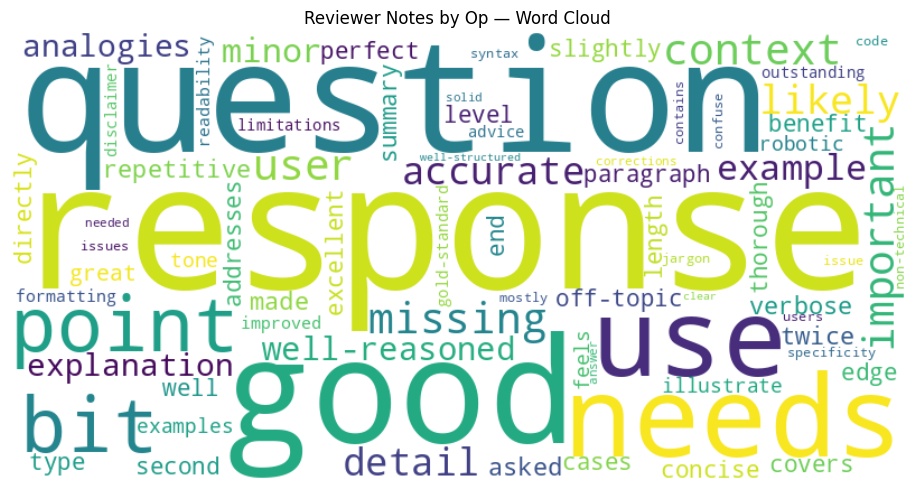

**Top 10 words by Op:**

,Op,#,Word,Count
0,weave.completions_create,1,response,38
1,weave.completions_create,2,question,31
2,weave.completions_create,3,good,27
3,weave.completions_create,4,needs,24
4,weave.completions_create,5,use,22
5,weave.completions_create,6,point,20
6,weave.completions_create,7,bit,20
7,weave.completions_create,8,missing,16
8,weave.completions_create,9,important,16
9,weave.completions_create,10,context,16


### Response Tone

alt.Chart(...)

In [ ]:
# @title
if not enriched_df.empty:
    for ref_uri, spec in scorers.items():
        stype = scorer_ref_to_type[ref_uri]
        group = enriched_df[enriched_df["annotation_ref"] == ref_uri].copy()
        if group.empty:
            continue

        display(Markdown(f"### {spec.name}"))

        if stype == "boolean":
            group["value_str"] = group["value"].astype(str)
            agg = group.groupby(["op", "value_str"]).size().reset_index(name="Count")
            bar = alt.Chart(agg).mark_bar().encode(
                x=alt.X("op:N", title="Op"),
                y=alt.Y("Count:Q", title="Count"),
                color=alt.Color("value_str:N", title="Value"),
                xOffset="value_str:N",
                tooltip=["op", "value_str", "Count"],
            ).properties(title=f"{spec.name} by Op", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(bar)

        elif stype in ("integer", "number"):
            group["num"] = pd.to_numeric(group["value"], errors="coerce")
            scored = group.dropna(subset=["num"])
            if scored.empty:
                continue
            op_stats = scored.groupby("op")["num"].agg(["mean", "std", "count"]).reset_index()
            op_stats["std"] = op_stats["std"].fillna(0)
            op_stats["upper"] = op_stats["mean"] + op_stats["std"]
            op_stats["lower"] = op_stats["mean"] - op_stats["std"]

            bars = alt.Chart(op_stats).mark_bar().encode(
                x=alt.X("op:N", title="Op", sort="-y"),
                y=alt.Y("mean:Q", title="Mean Score"),
                color=alt.Color("op:N", legend=None),
                tooltip=["op", "mean", "std", "count"],
            )
            errorbars = alt.Chart(op_stats).mark_errorbar().encode(
                x=alt.X("op:N"),
                y=alt.Y("lower:Q", title="Mean Score"),
                y2=alt.Y2("upper:Q"),
            )
            chart = (bars + errorbars).properties(
                title=f"{spec.name} by Op (Mean ± Std Dev)",
                width=CHART_WIDTH, height=CHART_HEIGHT,
            )
            display(chart)

            best = op_stats.loc[op_stats["mean"].idxmax()]
            worst = op_stats.loc[op_stats["mean"].idxmin()]
            delta = best["mean"] - worst["mean"]
            display(Markdown(
                f"**Best:** {best['op']} ({best['mean']:.2f}) · "
                f"**Worst:** {worst['op']} ({worst['mean']:.2f}) · "
                f"**Delta:** {delta:.2f}"
            ))

        elif stype == "string_enum":
            agg = group.groupby(["op", "value"]).size().reset_index(name="Count")
            bar = alt.Chart(agg).mark_bar().encode(
                x=alt.X("op:N", title="Op"),
                y=alt.Y("Count:Q", title="Count"),
                color=alt.Color("value:N", title="Value"),
                xOffset="value:N",
                tooltip=["op", "value", "Count"],
            ).properties(title=f"{spec.name} by Op", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(bar)

        elif stype == "string_free":
            op_groups = group.groupby("op")["value"].apply(list)
            all_vals = [v for vals in op_groups for v in vals if pd.notna(v)]
            wc_freq = dict(_top_words(all_vals, n=200))
            if wc_freq:
                wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(wc_freq)
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.imshow(wc, interpolation="bilinear")
                ax.axis("off")
                ax.set_title(f"{spec.name} by Op — Word Cloud")
                plt.tight_layout()
                display(fig)
                plt.close(fig)

            display(Markdown(f"**Top 10 words by Op:**"))
            rows = []
            for op_name, vals in op_groups.items():
                for rank, (w, c) in enumerate(_top_words(vals), 1):
                    rows.append({"Op": op_name, "#": rank, "Word": w, "Count": c})
            if rows:
                display(pd.DataFrame(rows))
else:
    display(Markdown("*No feedback data yet.*"))

### Scores By Model
Same breakdowns as Scores by Op, but grouped by the model associated with each call.
Boolean scorers use grouped bars (True vs False), numeric scorers show mean ± std dev,
string enums use grouped bars per value, and free-text strings use word clouds.

### Factually Correct

alt.Chart(...)

### Overall Quality

alt.LayerChart(...)

**Best:** gpt-4-turbo (3.29) · **Worst:** gpt-4o-mini-2024-07-18 (3.09) · **Delta:** 0.20

### Helpfulness

alt.LayerChart(...)

**Best:** gpt-4-turbo (6.83) · **Worst:** gpt-4o-mini-2024-07-18 (6.01) · **Delta:** 0.82

### Reviewer Notes

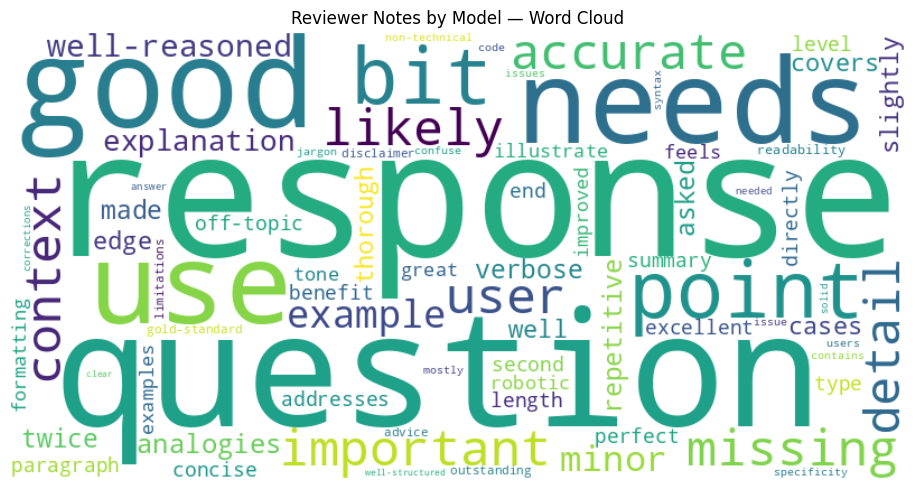

**Top 10 words by Model:**

,Model,#,Word,Count
0,gpt-4-turbo,1,use,3
1,gpt-4-turbo,2,response,2
2,gpt-4-turbo,3,mostly,2
3,gpt-4-turbo,4,accurate,2
4,gpt-4-turbo,5,minor,2
5,gpt-4-turbo,6,issues,2
6,gpt-4-turbo,7,specificity,2
7,gpt-4-turbo,8,clear,1
8,gpt-4-turbo,9,well-structured,1
9,gpt-4-turbo,10,great,1


### Response Tone

alt.Chart(...)

In [ ]:
# @title
if not enriched_df.empty:
    for ref_uri, spec in scorers.items():
        stype = scorer_ref_to_type[ref_uri]
        group = enriched_df[enriched_df["annotation_ref"] == ref_uri].copy()
        if group.empty:
            continue

        display(Markdown(f"### {spec.name}"))

        if stype == "boolean":
            group["value_str"] = group["value"].astype(str)
            agg = group.groupby(["model", "value_str"]).size().reset_index(name="Count")
            bar = alt.Chart(agg).mark_bar().encode(
                x=alt.X("model:N", title="Model"),
                y=alt.Y("Count:Q", title="Count"),
                color=alt.Color("value_str:N", title="Value"),
                xOffset="value_str:N",
                tooltip=["model", "value_str", "Count"],
            ).properties(title=f"{spec.name} by Model", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(bar)

        elif stype in ("integer", "number"):
            group["num"] = pd.to_numeric(group["value"], errors="coerce")
            scored = group.dropna(subset=["num"])
            if scored.empty:
                continue
            model_stats = scored.groupby("model")["num"].agg(["mean", "std", "count"]).reset_index()
            model_stats["std"] = model_stats["std"].fillna(0)
            model_stats["upper"] = model_stats["mean"] + model_stats["std"]
            model_stats["lower"] = model_stats["mean"] - model_stats["std"]

            bars = alt.Chart(model_stats).mark_bar().encode(
                x=alt.X("model:N", title="Model", sort="-y"),
                y=alt.Y("mean:Q", title="Mean Score"),
                color=alt.Color("model:N", legend=None),
                tooltip=["model", "mean", "std", "count"],
            )
            errorbars = alt.Chart(model_stats).mark_errorbar().encode(
                x=alt.X("model:N"),
                y=alt.Y("lower:Q", title="Mean Score"),
                y2=alt.Y2("upper:Q"),
            )
            chart = (bars + errorbars).properties(
                title=f"{spec.name} by Model (Mean ± Std Dev)",
                width=CHART_WIDTH, height=CHART_HEIGHT,
            )
            display(chart)

            best = model_stats.loc[model_stats["mean"].idxmax()]
            worst = model_stats.loc[model_stats["mean"].idxmin()]
            delta = best["mean"] - worst["mean"]
            display(Markdown(
                f"**Best:** {best['model']} ({best['mean']:.2f}) · "
                f"**Worst:** {worst['model']} ({worst['mean']:.2f}) · "
                f"**Delta:** {delta:.2f}"
            ))

        elif stype == "string_enum":
            agg = group.groupby(["model", "value"]).size().reset_index(name="Count")
            bar = alt.Chart(agg).mark_bar().encode(
                x=alt.X("model:N", title="Model"),
                y=alt.Y("Count:Q", title="Count"),
                color=alt.Color("value:N", title="Value"),
                xOffset="value:N",
                tooltip=["model", "value", "Count"],
            ).properties(title=f"{spec.name} by Model", width=CHART_WIDTH, height=CHART_HEIGHT)
            display(bar)

        elif stype == "string_free":
            model_groups = group.groupby("model")["value"].apply(list)
            all_vals = [v for vals in model_groups for v in vals if pd.notna(v)]
            wc_freq = dict(_top_words(all_vals, n=200))
            if wc_freq:
                wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(wc_freq)
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.imshow(wc, interpolation="bilinear")
                ax.axis("off")
                ax.set_title(f"{spec.name} by Model — Word Cloud")
                plt.tight_layout()
                display(fig)
                plt.close(fig)

            display(Markdown(f"**Top 10 words by Model:**"))
            rows = []
            for model_name, vals in model_groups.items():
                for rank, (w, c) in enumerate(_top_words(vals), 1):
                    rows.append({"Model": model_name, "#": rank, "Word": w, "Count": c})
            if rows:
                display(pd.DataFrame(rows))
else:
    display(Markdown("*No feedback data yet.*"))

### Scorer: Correlation
Pearson correlation heatmap between all numeric scorers. Each cell shows
how strongly two scorers co-vary across calls. Values near +1 indicate
strong positive correlation; near -1 indicates inverse correlation.

In [ ]:
# @title
if not feedback_df.empty:
    numeric_refs = [ref for ref, st in scorer_ref_to_type.items() if st in ("integer", "number")]

    if len(numeric_refs) >= 2:
        fb_numeric = feedback_df[feedback_df["annotation_ref"].isin(numeric_refs)].copy()
        fb_numeric["num"] = pd.to_numeric(fb_numeric["value"], errors="coerce")
        pivot = fb_numeric.pivot_table(index="call_id", columns="scorer_name", values="num", aggfunc="mean")
        corr = pivot.corr()

        corr_long = corr.reset_index().melt(id_vars="scorer_name", var_name="Scorer B", value_name="Correlation")
        corr_long = corr_long.rename(columns={"scorer_name": "Scorer A"})

        heatmap = alt.Chart(corr_long).mark_rect().encode(
            x=alt.X("Scorer A:N", title=""),
            y=alt.Y("Scorer B:N", title=""),
            color=alt.Color("Correlation:Q", scale=alt.Scale(scheme="blues", domain=[-1, 1])),
            tooltip=["Scorer A", "Scorer B", alt.Tooltip("Correlation:Q", format=".3f")],
        ).properties(title="Scorer Correlation Matrix", width=CHART_WIDTH, height=CHART_HEIGHT)

        text = alt.Chart(corr_long).mark_text(fontSize=14).encode(
            x=alt.X("Scorer A:N"),
            y=alt.Y("Scorer B:N"),
            text=alt.Text("Correlation:Q", format=".2f"),
        )
        display(heatmap + text)
    else:
        display(Markdown("*Need 2+ numeric scorers for correlation analysis.*"))
else:
    display(Markdown("*No feedback data yet.*"))

alt.LayerChart(...)

## Annotator Result Analysis

### Inter-Annotator Agreement
Measures how consistently different annotators score the same calls.
Boolean scorers are skipped. For numeric scorers, the top-5 most disagreed
calls (highest within-call std dev) are listed. For string enum scorers,
the distribution of agreement and top-5 most divergent calls are shown.

In [ ]:
# @title
if not feedback_df.empty:
    for ref_uri, spec in scorers.items():
        stype = scorer_ref_to_type[ref_uri]
        group = feedback_df[feedback_df["annotation_ref"] == ref_uri].copy()
        multi = group.groupby("call_id").filter(lambda g: g["annotator"].nunique() > 1)
        if multi.empty:
            continue

        if stype in ("boolean", "string_free"):
            continue

        n_calls = multi["call_id"].nunique()
        display(Markdown(f"### {spec.name} ({n_calls} calls with 2+ annotators)"))

        if stype in ("integer", "number"):
            multi = multi.copy()
            multi["num"] = pd.to_numeric(multi["value"], errors="coerce")
            per_call = multi.groupby("call_id")["num"].agg(["std", "min", "max", "count"]).reset_index()
            per_call = per_call.dropna(subset=["std"])
            worst5 = per_call.nlargest(5, "std")

            display(Markdown("**Top 5 most disagreed calls:**"))
            rows = []
            for _, row in worst5.iterrows():
                cid = row["call_id"]
                rows.append({
                    "Call ID": cid,
                    "Op": short_op(call_op_map.get(cid, "(unknown)")),
                    "Model": call_model_map.get(cid, "(unknown)"),
                    "URL": call_url(cid),
                    "Spread": f"{row['max'] - row['min']:.1f}",
                    "Std Dev": f"{row['std']:.2f}",
                })
            display(pd.DataFrame(rows))

        elif stype == "string_enum":
            exact = multi.groupby("call_id")["value"].apply(lambda v: v.nunique() == 1)
            agreement_rate = exact.mean() * 100
            display(Markdown(f"**Exact agreement rate:** {agreement_rate:.1f}%"))

            disagreed = exact[~exact].index.tolist()[:5]
            if disagreed:
                display(Markdown("**Top 5 most divergent calls:**"))
                display(_make_call_table(disagreed))
else:
    display(Markdown("*No feedback data yet.*"))

### Overall Quality (75 calls with 2+ annotators)

**Top 5 most disagreed calls:**

,Call ID,Op,Model,URL,Spread,Std Dev
0,0193559a-8058-7043-a570-d597834828a7,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...,4.0,2.83
1,01935589-d0d1-7362-8038-62084d4d29b9,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...,3.0,2.12
2,01935647-b2dc-7011-aefa-27aa682e0226,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...,3.0,2.12
3,01939efc-844b-7cf1-b911-249b48ec110d,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...,3.0,2.12
4,01939f0d-e15a-73f1-8e58-b8858571b414,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...,3.0,2.12


### Helpfulness (75 calls with 2+ annotators)

**Top 5 most disagreed calls:**

,Call ID,Op,Model,URL,Spread,Std Dev
0,019355bf-7410-7aa2-8f31-cc7daec54c4f,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...,6.2,4.38
1,019355a1-8893-73d2-9905-462fcc287e0c,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...,5.6,3.96
2,01935646-68e4-7770-96ac-a74efbb83360,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...,4.6,3.25
3,0193559a-8058-7043-a570-d597834828a7,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...,3.9,2.76
4,01939efc-844b-7cf1-b911-249b48ec110d,weave.completions_create,gpt-4o-mini-2024-07-18,https://wandb.ai/wandb-designers/martin-weave-...,3.9,2.76


### Response Tone (75 calls with 2+ annotators)

**Exact agreement rate:** 37.3%

**Top 5 most divergent calls:**

,Call ID,Op,Model,URL
0,01935568-cea4-7051-9939-b3ad8f1625f6,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
1,01935569-4fd4-7ec3-93ce-a809834afa42,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
2,01935569-9585-7412-a3aa-407e8766b444,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...
3,0193556a-c612-7df0-8437-0021b3210bbe,weave.completions_create,gpt-4o-mini,https://wandb.ai/wandb-designers/martin-weave-...
4,0193556a-c999-7b70-9e66-6951c7c50bb1,weave.completions_create,gpt-4-turbo,https://wandb.ai/wandb-designers/martin-weave-...


### Annotator Scorer Matrix
Heatmap of annotator x scorer average scores. Each cell shows the mean
numeric score an annotator gave for a particular scorer, revealing
systematic patterns across annotators and scoring dimensions.

In [ ]:
# @title
if not feedback_df.empty:
    numeric_refs = [ref for ref, st in scorer_ref_to_type.items() if st in ("integer", "number")]
    numeric_fb = feedback_df[feedback_df["annotation_ref"].isin(numeric_refs)].copy()

    if not numeric_fb.empty:
        numeric_fb["num"] = pd.to_numeric(numeric_fb["value"], errors="coerce")
        pivot = numeric_fb.pivot_table(
            index="annotator", columns="scorer_name", values="num", aggfunc="mean"
        )

        heatmap_data = pivot.reset_index().melt(id_vars="annotator", var_name="Scorer", value_name="Avg Score")
        heatmap_data = heatmap_data.dropna(subset=["Avg Score"])

        heatmap = alt.Chart(heatmap_data).mark_rect().encode(
            x=alt.X("Scorer:N", title="Scorer"),
            y=alt.Y("annotator:N", title="Annotator"),
            color=alt.Color("Avg Score:Q", scale=alt.Scale(scheme="blues")),
            tooltip=["annotator", "Scorer", alt.Tooltip("Avg Score:Q", format=".2f")],
        ).properties(title="Annotator × Scorer Matrix (Avg Score)", width=CHART_WIDTH, height=CHART_HEIGHT)

        text = alt.Chart(heatmap_data).mark_text(fontSize=12).encode(
            x=alt.X("Scorer:N"),
            y=alt.Y("annotator:N"),
            text=alt.Text("Avg Score:Q", format=".2f"),
        )
        display(heatmap + text)
    else:
        display(Markdown("*No numeric scorer data available.*"))
else:
    display(Markdown("*No feedback data yet.*"))

alt.LayerChart(...)

### Annotator Bias
For each numeric scorer, shows each annotator's deviation from the global mean
as a diverging bar chart — bars above zero (blue) indicate the annotator scores
higher than average, bars below (red) indicate lower. The dashed line marks the mean.

In [ ]:
# @title
if not feedback_df.empty:
    for ref_uri, spec in scorers.items():
        stype = scorer_ref_to_type[ref_uri]
        if stype not in ("integer", "number"):
            continue
        group = feedback_df[feedback_df["annotation_ref"] == ref_uri].copy()
        group["num"] = pd.to_numeric(group["value"], errors="coerce")
        scored = group.dropna(subset=["num"])
        if scored.empty:
            continue

        global_mean = scored["num"].mean()
        global_std = scored["num"].std()

        bias_rows = []
        for ann, agrp in scored.groupby("annotator"):
            m = agrp["num"].mean()
            z = (m - global_mean) / global_std if global_std > 0 else 0
            bias_rows.append({
                "Annotator": ann or "(unknown)",
                "Mean": m,
                "Bias": m - global_mean,
                "z-score": z,
                "n": len(agrp),
                "Significant": abs(z) > 1.5,
            })
        bias_df = pd.DataFrame(bias_rows)

        bars = alt.Chart(bias_df).mark_bar().encode(
            x=alt.X("Annotator:N", title="Annotator"),
            y=alt.Y("Bias:Q", title="Deviation from Mean", scale=alt.Scale(zero=True)),
            color=alt.Color("Annotator:N", legend=None),
            tooltip=["Annotator", alt.Tooltip("Mean:Q", format=".2f"),
                     alt.Tooltip("Bias:Q", format="+.2f"),
                     alt.Tooltip("z-score:Q", format="+.2f"), "n"],
        )

        rule = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
            strokeDash=[4, 4], color="black", strokeWidth=1.5,
        ).encode(y="y:Q")

        chart = (bars + rule).properties(
            title=f"{spec.name} — Annotator Bias (global mean = {global_mean:.2f})",
            width=CHART_WIDTH, height=CHART_HEIGHT,
        )
        display(chart)
else:
    display(Markdown("*No feedback data yet.*"))

alt.LayerChart(...)

alt.LayerChart(...)

## Raw Data
The full feedback DataFrame used to generate this report, with op and model columns joined in.

In [ ]:
if not enriched_df.empty:
    display(enriched_df)
else:
    display(Markdown("*No data.*"))

,call_id,annotation_ref,annotator,feedback_id,scorer_name,scorer_type,value,created_at,model,op_name_full,op
0,01935567-a7e5-7122-9470-b083f86202cd,weave:///wandb-designers/martin-weave-test/obj...,martin-mark,019c7675-04fb-755a-b09c-8fe1cd30c56c,Factually Correct,boolean,True,2026-02-19 15:11:47.112000+00:00,gpt-4o-mini,weave.completions_create,weave.completions_create
1,01935567-a7e5-7122-9470-b083f86202cd,weave:///wandb-designers/martin-weave-test/obj...,martinmark,019c7688-4ed1-7a79-9dba-01ec56ffcaca,Factually Correct,boolean,True,2026-02-19 15:32:55.035000+00:00,gpt-4o-mini,weave.completions_create,weave.completions_create
2,01935567-a7e5-7122-9470-b083f86202cd,weave:///wandb-designers/martin-weave-test/obj...,martin-mark,019c7675-04fe-7676-9b5c-9f08ed5f4f43,Helpfulness,number,6.2,2026-02-19 15:11:47.193000+00:00,gpt-4o-mini,weave.completions_create,weave.completions_create
3,01935567-a7e5-7122-9470-b083f86202cd,weave:///wandb-designers/martin-weave-test/obj...,martinmark,019c7688-4ed1-77b8-9f44-bef533cd717e,Helpfulness,number,6.0,2026-02-19 15:32:55.220000+00:00,gpt-4o-mini,weave.completions_create,weave.completions_create
4,01935567-a7e5-7122-9470-b083f86202cd,weave:///wandb-designers/martin-weave-test/obj...,martin-mark,019c7675-04fe-7f39-ac49-96152538b1d8,Overall Quality,integer,4,2026-02-19 15:11:47.152000+00:00,gpt-4o-mini,weave.completions_create,weave.completions_create
...,...,...,...,...,...,...,...,...,...,...,...
870,0193a331-43c9-7c22-8488-1bfd707ccc15,weave:///wandb-designers/martin-weave-test/obj...,martin-mark,019c7675-613e-7b8f-9ea8-d130d54bab0d,Factually Correct,boolean,True,2026-02-19 15:12:33.547000+00:00,gpt-4o-mini-2024-07-18,weave.completions_create,weave.completions_create
871,0193a331-43c9-7c22-8488-1bfd707ccc15,weave:///wandb-designers/martin-weave-test/obj...,martin-mark,019c7675-613e-75a1-95ab-206732bf31aa,Helpfulness,number,5.3,2026-02-19 15:12:33.697000+00:00,gpt-4o-mini-2024-07-18,weave.completions_create,weave.completions_create
872,0193a331-43c9-7c22-8488-1bfd707ccc15,weave:///wandb-designers/martin-weave-test/obj...,martin-mark,019c7675-613e-75e1-979d-9c2a475c0833,Overall Quality,integer,4,2026-02-19 15:12:33.602000+00:00,gpt-4o-mini-2024-07-18,weave.completions_create,weave.completions_create
873,0193a331-43c9-7c22-8488-1bfd707ccc15,weave:///wandb-designers/martin-weave-test/obj...,martin-mark,019c7675-613e-7785-bb45-c9476a7122ec,Response Tone,string,Friendly,2026-02-19 15:12:33.847000+00:00,gpt-4o-mini-2024-07-18,weave.completions_create,weave.completions_create
